# Data Slayer 2.0 - Motion Matters: Human Fall Detection Classification for Safety Insight

# Developed by: Kecoa Terbang


Fall Detection merupakan salah satu penerapan teknologi informasi yang memungkinkan mengidentifikasi peristiwa jatuhnya manusia secara otomatis melalui sensor atau visi komputer. Pengimplementasian Fall Detection diharapkan dapat melakukan deteksi dini dalam mengenali kejadian jatuh yang dapat berdampak serius, terutama pada kelompok rentan seperti lansia dan disabilitas.

Project ini bertujuan untuk menklasifikasikan sebuah citra statis kedalam dua kategori, *fall* dan *non_fall* menggunakan teknologi kecerdasan buatan. Analisis data dan *machine learning* akan digunakan untuk menciptakan sebuah model yang dapat mengidentifikasikan gerakan jatuh. Dataset yang disediakan merupakan dataset

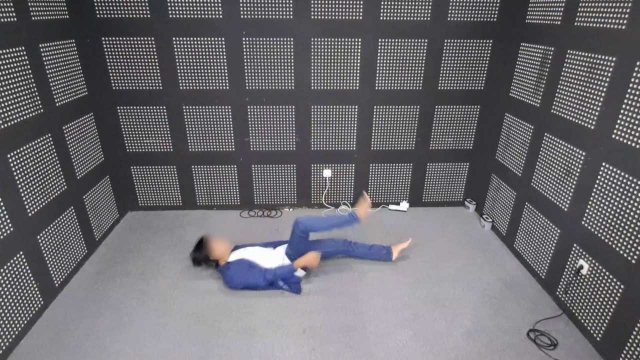

# 1. Preparation

## 1.1. Load Dependencies

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Sampler, Dataset, DataLoader
from torchvision import transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import cv2

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import shutil

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score

import random
import os
import copy
import gc
import re
import warnings

from google.colab import userdata

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1.2. Download Dataset

In [ ]:
data_path = "/content/data-slayer-2-0-machine-learning-competition.zip"

# ==== UN-COMMENT JIKA ANDA AKAN MEN-DOWNLOAD DATASET DARI KAGGLE COMPETITION ====
# os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
# os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

# if os.path.exists(data_path) == False:
#   !kaggle competitions download -c data-slayer-2-0-machine-learning-competition
#   !unzip -q data-slayer-2-0-machine-learning-competition.zip -d data

# ==== UN-COMMENT JIKA ANDA AKAN MEN-DOWNLOAD DATASET DARI S3 BUCKET (TIDAK BUTUH CREDENTIAL) ====
if os.path.exists(data_path) == False:
  !wget https://dataslayer-bucket.s3.us-east-1.amazonaws.com/data-slayer-2-0-machine-learning-competition.zip
  !unzip -q data-slayer-2-0-machine-learning-competition.zip -d data

--2024-12-25 15:45:07--  https://dataslayer-bucket.s3.us-east-1.amazonaws.com/data-slayer-2-0-machine-learning-competition.zip
Resolving dataslayer-bucket.s3.us-east-1.amazonaws.com (dataslayer-bucket.s3.us-east-1.amazonaws.com)... 52.217.50.56, 16.15.176.113, 52.217.84.144, ...
Connecting to dataslayer-bucket.s3.us-east-1.amazonaws.com (dataslayer-bucket.s3.us-east-1.amazonaws.com)|52.217.50.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 653264804 (623M) [application/zip]
Saving to: ‘data-slayer-2-0-machine-learning-competition.zip’

data-slayer-2-0-mac 100%[===================>] 623.00M  6.66MB/s    in 87s     

2024-12-25 15:46:35 (7.20 MB/s) - ‘data-slayer-2-0-machine-learning-competition.zip’ saved [653264804/653264804]



# 2. Exploratory Data Analysis

## 2.1. Understanding Data Structure

Pertama-tama, mari kita lihat struktur *directory* dari data yang telah diberikan.

In [ ]:
import os

def visualize_directory_structure(directory, indent=0, image_limit=0):
    """
    Visualize the directory structure with indentation, displaying only image files up to the specified limit.

    :param directory: Path to the directory.
    :param indent: Indentation level for nested files/folders.
    :param image_limit: Maximum number of image files to display per directory.
    """
    try:
        # List the files and directories
        items = os.listdir(directory)
    except PermissionError:
        print(" " * indent + "[Permission Denied]")
        return

    directories = [item for item in items if os.path.isdir(os.path.join(directory, item))]
    files = [item for item in items if os.path.isfile(os.path.join(directory, item))]
    image_files = [file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]

    # Print directories first
    for dir_name in directories:
        print(" " * indent + f"📁 {dir_name}")
        visualize_directory_structure(os.path.join(directory, dir_name), indent + 4, image_limit)

    # Print image files up to the limit
    for image in image_files[:image_limit]:
        print(" " * indent + f"📄 {image}")

    # Indicate if there are more items not shown
    if len(image_files) > image_limit:
        print(" " * indent + f"{len(image_files) - image_limit} images")

# Example usage
start_directory = "/content/data"  # Change this to the directory you want to visualize
visualize_directory_structure(start_directory)


📁 train
    📁 subject-4
        📁 non_fall
            📁 4_squat
                122 images
            📁 4_stretching
                144 images
            📁 4_walking
                134 images
            📁 4_laying
                122 images
            📁 4_jumping
                128 images
            📁 4_picking
                166 images
        📁 fall
            📁 4_standing_falls
                68 images
            📁 4_right_falls
                69 images
            📁 4_backward_falls
                62 images
            📁 4_left_falls
                61 images
            📁 4_forward_falls
                63 images
            📁 4_sitting_falls
                102 images
    📁 subject-3
        📁 non_fall
            📁 3_laying
                118 images
            📁 3_squat
                118 images
            📁 3_stretching
                124 images
            📁 3_jumping
                124 images
            📁 3_picking
                170 images
            

Berikut merupakan analisis dari directory yang telah divisualisasikan:
- Direktori Train terdiri atas kumpulan gambar yang diambil dari 4 *subject*. Tiap subject melakukan peraga dua jenis *label* yang menjadi *objective* pada task ini, yaitu *fall* dan *non_fall*. Gambar untuk tiap *label* berada di dalam direktori masing masing.
- Masing-masing *label* *fall* dan *non_fall* memiliki *sub-label*. Label *fall* memiliki *sub-label* *forward fall, backward fall, left fall, right fall, sitting fall, dan standing fall*. Adapun *label* *non_fall* memiliki *sub-label stretching, laying, squat, walking, picking, dan jumping*.
- Direktori Test terdiri atas kumpulan gambar yang tidak dilabeli

## 2.2. Understanding Data Distribution between Class

### 2.2.1. Train vs Test Data Distribution

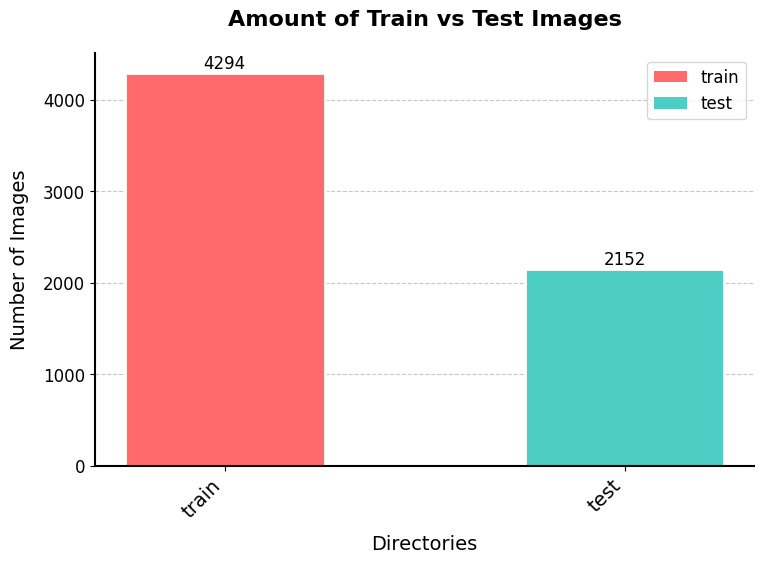

In [ ]:
def visualize_directory_structure(directory, indent=0, image_limit=0):
  """
  Visualize the directory structure with indentation, displaying only image files up to the specified limit.

  :param directory: Path to the directory.
  :param indent: Indentation level for nested files/folders.
  :param image_limit: Maximum number of image files to display per directory.
  """
  try:
    # List the files and directories
    items = os.listdir(directory)
  except PermissionError:
    print(" " * indent + "[Permission Denied]")
    return

  directories = [item for item in items if os.path.isdir(os.path.join(directory, item))]
  files = [item for item in items if os.path.isfile(os.path.join(directory, item))]
  image_files = [file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]

  # Count image files
  image_counts = {}
  for dir_name in directories:
    sub_dir = os.path.join(directory, dir_name)
    image_counts[dir_name] = count_images_in_directory(sub_dir)

  # Visualize with bar chart (using NumPy for positioning)
  plt.figure(figsize=(8, 6))  # Increased figure size

  bar_width = 0.5
  bar_positions = np.arange(len(image_counts.keys()))

  colors = ['#FF6B6B', '#4ECDC4']  # Same color palette

  bars = plt.bar(bar_positions, image_counts.values(), bar_width, color=colors, edgecolor='white', linewidth=2, zorder=2)

  # Add data labels on top of bars
  for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), va='bottom', ha='center', fontsize=12, color='black')

  # Customize axes and title
  plt.xticks(bar_positions, image_counts.keys(), fontsize=14, rotation=45, ha="right")
  plt.yticks(fontsize=12)
  plt.ylabel("Number of Images", fontsize=14, labelpad=10)
  plt.xlabel("Directories", fontsize=14, labelpad=10)
  plt.title("Amount of Train vs Test Images", fontsize=16, fontweight='bold', pad=20)

  # Add a subtle grid
  plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)

  # Improved Spines (border of the graph)
  ax = plt.gca()
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_linewidth(1.5)
  ax.spines['left'].set_linewidth(1.5)

  # Improved Legend (optional but good practice)
  if len(colors) > 1:  # Only show legend if there are multiple colors
    patches = [mpatches.Patch(facecolor=color, label=label) for color, label in zip(colors, image_counts.keys())]
    plt.legend(handles=patches, fontsize=12, loc='upper right', framealpha=0.8)

  plt.tight_layout(pad=2)
  plt.show()


def count_images_in_directory(directory):
  """
  Counts the number of image files in a given directory.
  """
  count = 0
  for root, _, files in os.walk(directory):
    for file in files:
      if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
        count += 1
  return count

# Example usage
start_directory = "/content/data"  # Change this to the directory you want to visualize
visualize_directory_structure(start_directory)


Bisa kita lihat bahwa perbandingan antara data train dengan data test berada pada rasio 2:1 . Kedepannya, kita juga menemukan bahwa data test menggunakan dua orang peraga yang mana orangnya berbeda dengan peraga pada data train

### 2.2.2. Fall vs Non-Fall Data Distribution in Training Dataset

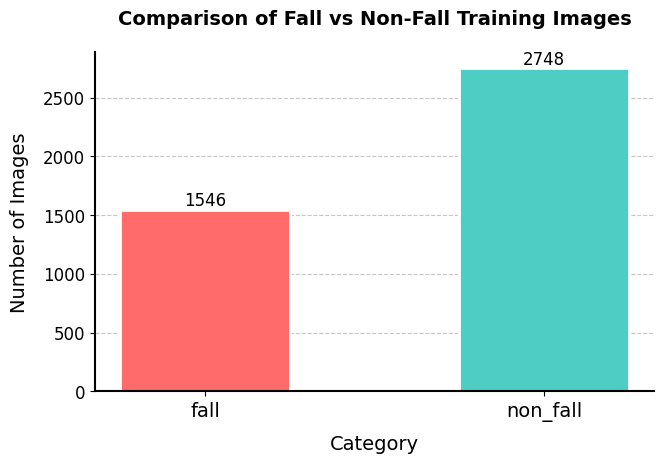

In [ ]:
def count_images(root_dir):
    """Counts images in fall and non-fall directories for each subject."""
    counts = {"fall": 0, "non_fall": 0}
    for subject_dir in os.listdir(root_dir):
        subject_path = os.path.join(root_dir, subject_dir)
        if os.path.isdir(subject_path):  # Ensure it's a directory
            for category in ["fall", "non_fall"]:
                category_path = os.path.join(subject_path, category)
                if os.path.isdir(category_path):
                    for action_dir in os.listdir(category_path):
                        action_path = os.path.join(category_path, action_dir)
                        if os.path.isdir(action_path):
                            num_images = len([f for f in os.listdir(action_path) if os.path.isfile(os.path.join(action_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))])
                            counts[category] += num_images
    return counts

if __name__ == "__main__":
    train_dir = "/content/data/train"
    train_counts = count_images(train_dir)

    labels = list(train_counts.keys())
    values = list(train_counts.values())

    # Fancy Visualization
    plt.figure(figsize=(7, 5), dpi=100)  # Increased figure size and DPI
    bar_width = 0.5
    bar_positions = np.arange(len(labels))

    colors = ['#FF6B6B', '#4ECDC4']  # Nicer color palette
    bars = plt.bar(bar_positions, values, bar_width, color=colors, edgecolor='white', linewidth=2, zorder=2) #added edge, linewidth, zorder

    # Add data labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontsize=12, color='black') #added fontsize and color

    # Customize axes and title
    plt.xticks(bar_positions, labels, fontsize=14)
    plt.yticks(fontsize=12)
    plt.ylabel("Number of Images", fontsize=14, labelpad=10)
    plt.xlabel("Category", fontsize=14, labelpad=10)
    plt.title("Comparison of Fall vs Non-Fall Training Images", fontsize=14, fontweight='bold', pad=20) #added pad

    # Add a subtle grid
    plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=1) #added zorder

    # Improved Spines (border of the graph)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)

    # Add a legend (optional but good practice)
    patches = [mpatches.Patch(facecolor=color, label=label) for color, label in zip(colors, labels)]
    # plt.legend(handles=patches, fontsize=12, loc='upper right', framealpha=0.8) #added framealpha

    plt.tight_layout(pad=2) #added pad
    plt.show()

Bisa kita lihat bahwa data train yang kita miliki merupakan *class imbalance dataset* dimana data dengan label *non_fall* hampir dua kali lipat dibandingkan data dengan label *fall*.

### 2.2.3. Data Distribution among Sub-Label

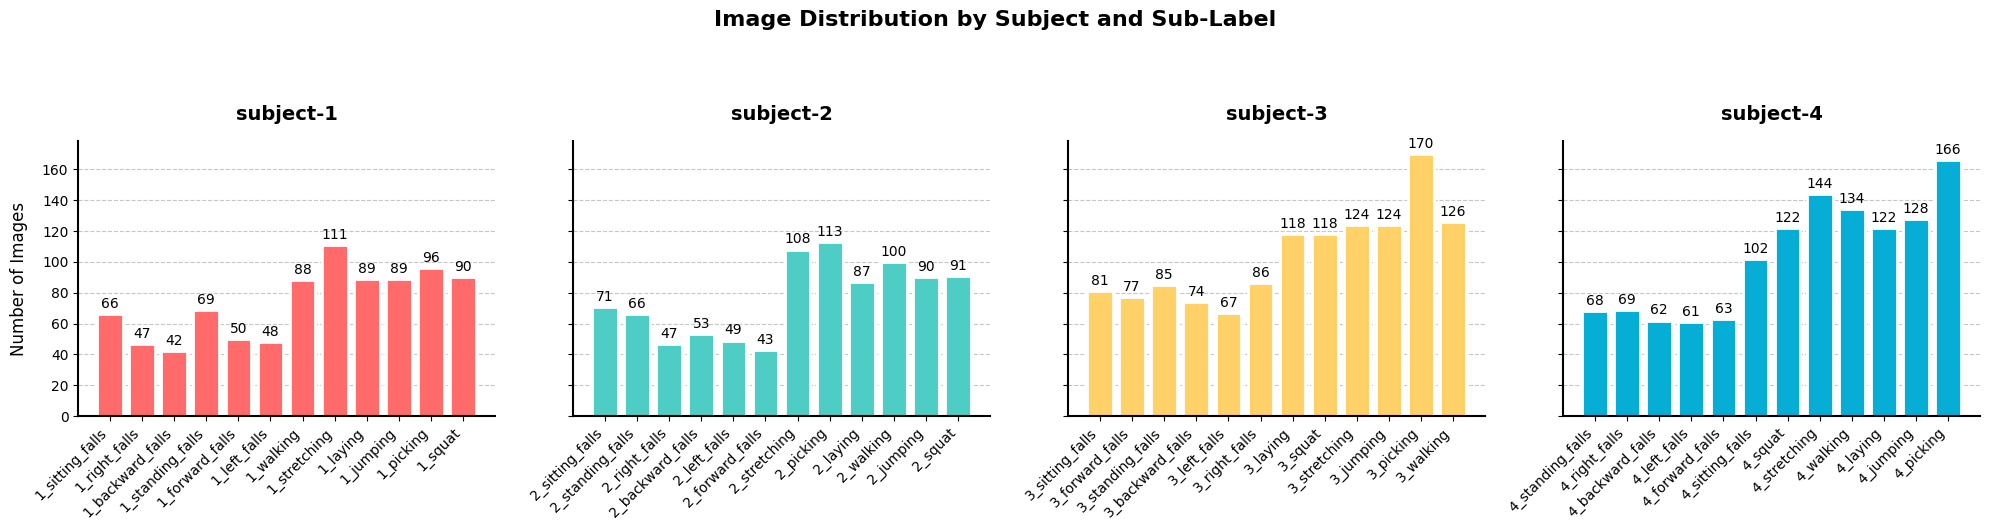

In [ ]:
def visualize_directory_structure(directory):
    """Visualizes image counts for sub-labels within a directory, sorting subjects."""

    subject_data = {}
    for subject_dir in os.listdir(directory):
        subject_path = os.path.join(directory, subject_dir)
        if os.path.isdir(subject_path):
            subject_data[subject_dir] = {}
            for category in ["fall", "non_fall"]:
                category_path = os.path.join(subject_path, category)
                if os.path.isdir(category_path):
                    for action_dir in os.listdir(category_path):
                        action_path = os.path.join(category_path, action_dir)
                        if os.path.isdir(action_path):
                            image_count = len([f for f in os.listdir(action_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))])
                            subject_data[subject_dir].setdefault(category, {}).update({action_dir: image_count})

    # Sort subject names (natural sorting for numerical prefixes)
    subject_names = sorted(subject_data.keys(), key=natural_sort)
    num_subjects = len(subject_names)

    fig, axes = plt.subplots(1, num_subjects, figsize=(num_subjects * 5, 5), sharey=True) #share y axis

    if num_subjects == 1:
        axes = [axes]  # make it iterable

    subject_colors = ['#FF6B6B', '#4ECDC4', '#FFD166', '#06AED5']  # Distinct colors for subjects

    for i, subject_name in enumerate(subject_names):
        ax = axes[i]
        subject_color = subject_colors[i % len(subject_colors)]

        all_labels = []
        all_counts = []
        for category in ["fall", "non_fall"]:
            if category in subject_data[subject_name]:
                for label, count in subject_data[subject_name][category].items():
                    all_labels.append(label)
                    all_counts.append(count)

        bar_positions = np.arange(len(all_labels))
        bars = ax.bar(bar_positions, all_counts, color=subject_color, edgecolor='white', linewidth=2, zorder=2)

        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, yval + 2, int(yval), va='bottom', ha='center', fontsize=10, color='black')

        ax.set_xticks(bar_positions)
        ax.set_xticklabels(all_labels, rotation=45, ha="right", fontsize=10)
        ax.set_title(f"{subject_name}", fontsize=14, fontweight='bold', pad=15)
        ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)

        if i == 0:
            ax.set_ylabel("Number of Images", fontsize=12, labelpad=10)

    plt.suptitle("Image Distribution by Subject and Sub-Label", fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def natural_sort(list_):
    """Sorts a list in natural order (handles numbers correctly)."""
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', str(key))]
    return sorted(list_, key=alphanum_key)

# Example usage
start_directory = "/content/data/train"
visualize_directory_structure(start_directory)

Pada diagram diatas, bisa kita lihat bahwa sub-class dari *non-fall* memiliki jumlah gambar yang lebih banyak dibandingkan sub-class dari *fall*. Bisa kita ketahui pula bahwa jumlah proporsi gambar dari tiap sub-class tidaklah sama antar subjek.

## 2.3. Take a Look to The Image

### 2.3.1. Visualize Image in One Class

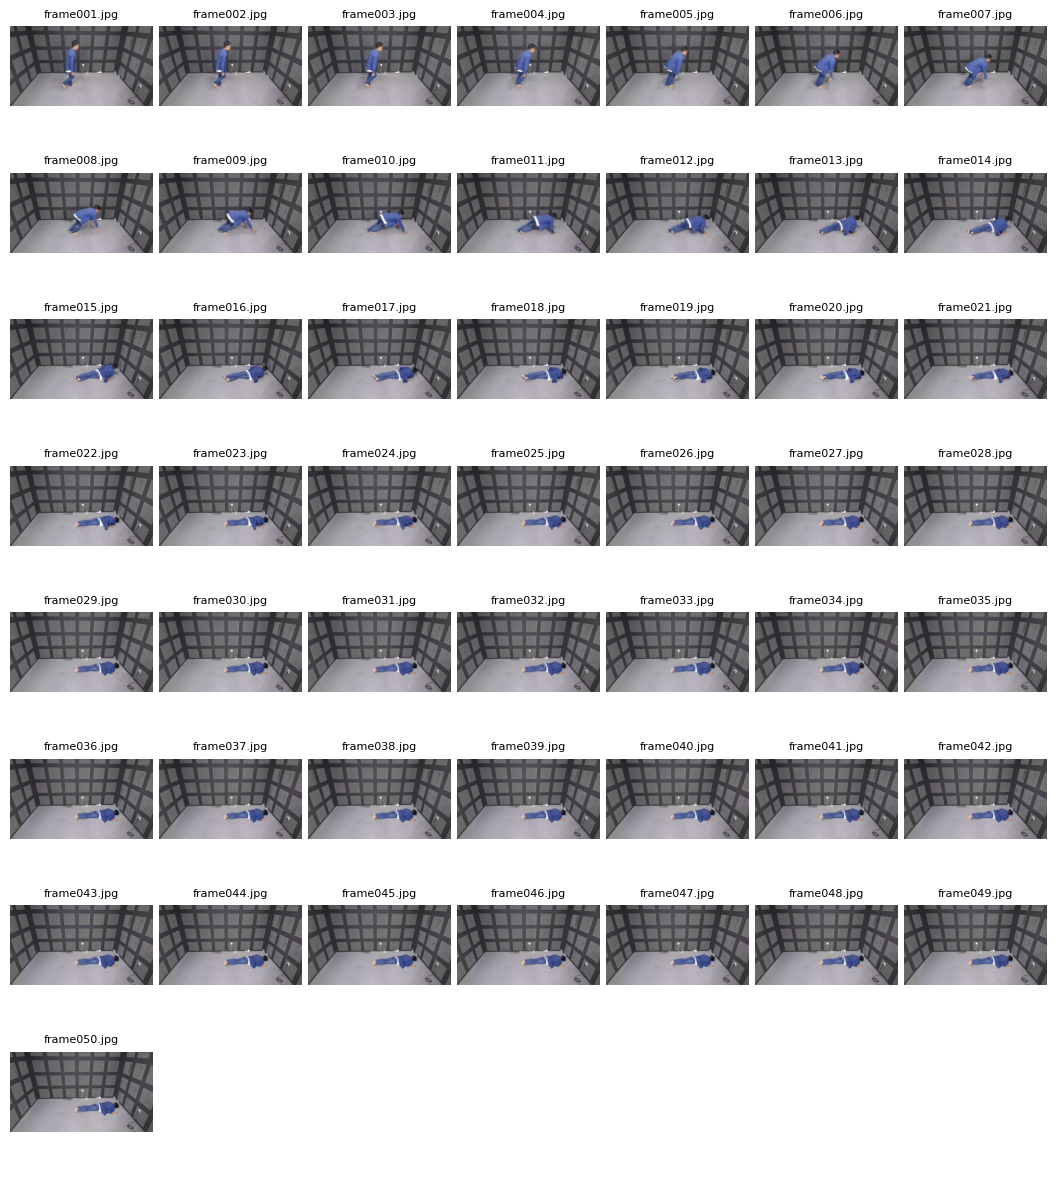

In [ ]:
def natural_sort(list_):
    """Sorts a list in natural order (handles numbers correctly)."""
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', str(key))]
    return sorted(list_, key=alphanum_key)

def visualize_images_from_folder(folder_path, images_per_row=5, max_images=50, image_size=(2, 2)):
    """
    Visualizes images from a given folder in a grid, sorted by filename.

    Args:
        folder_path: Path to the folder containing images.
        images_per_row: Number of images to display in each row.
        max_images: Maximum number of images to display. If 0, display all.
        image_size: Tuple (width, height) for the size of each image in inches.
    """

    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    if not image_files:
        print(f"No images found in folder: {folder_path}")
        return

    # Sort image files naturally
    image_files = natural_sort(image_files)

    if max_images > 0:
        image_files = image_files[:min(max_images, len(image_files))]  # Take the first max_images after sorting

    num_images = len(image_files)
    num_rows = (num_images + images_per_row - 1) // images_per_row

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * image_size[0], num_rows * image_size[1]))

    if num_rows == 1 and images_per_row == 1:
        axes = [[axes]]
    elif num_rows == 1:
        axes = [axes]
    elif images_per_row == 1:
        axes = [[ax] for ax in axes]

    for i, image_file in enumerate(image_files):
        row = i // images_per_row
        col = i % images_per_row
        image_path = os.path.join(folder_path, image_file)

        try:
            img = mpimg.imread(image_path)
            axes[row][col].imshow(img)
            axes[row][col].axis('off')
            axes[row][col].set_title(image_file, fontsize=8)
        except Exception as e:
            print(f"Error loading image {image_file}: {e}")
            axes[row][col].axis('off')
            axes[row][col].text(0.5, 0.5, "Error", ha='center', va='center', color='red')

    # Hide any unused subplots
    for i in range(num_images, num_rows * images_per_row):
        row = i // images_per_row
        col = i % images_per_row
        axes[row][col].axis('off')

    plt.tight_layout(pad=0.5)  # Reduced padding slightly
    plt.show()

# Example usage:
image_folder = "/content/data/train/subject-1/fall/1_forward_falls"  # Replace with your folder path
visualize_images_from_folder(image_folder, images_per_row=7, max_images=80, image_size=(1.5, 1.5))


Bisa kita lihat bahwa untuk satu sub-class oleh satu subyek, terdapat beberapa
 gambar dengan "pose" yang sama (subyek hampir tidak melakukan gerakan). Hal ini menjadi alasan mengapa kedepannya kami akan melakukan undersampling agar model tidak mengalami *overfit*

### 2.3.2. Take a sample of Image from Each sub-class from all subject

# 3. Data Preprocessing

## 3.1. Restructure The Directory

Langkah Preprocessing pertama adalah dengan menyesuaikan direktori dengan *task* yang akan diselesaikan. Kami merubah nama tiap image berdasarkan subject dan *sub-class*-nya dan mengubah struktur direktori *train dataset* menjadi *fall* dan *non-fall*.

In [ ]:
def reorganize_files(source_dir):
    """
    Reorganizes files, renaming, moving, consolidating, and robustly deleting empty directories.

    Args:
        source_dir: The root directory containing the data.
    """

    for subject in os.listdir(source_dir):
        subject_path = os.path.join(source_dir, subject)

        if os.path.isdir(subject_path):
            for activity_type in ["fall", "non_fall"]:
                activity_dir = os.path.join(subject_path, activity_type)

                if os.path.exists(activity_dir):
                    # Rename files within subdirectories
                    for subdir in os.listdir(activity_dir):
                        subdir_path = os.path.join(activity_dir, subdir)
                        if os.path.isdir(subdir_path):
                            for filename in os.listdir(subdir_path):
                                file_path = os.path.join(subdir_path, filename)
                                if os.path.isfile(file_path):
                                    new_filename = f"{subdir}_{filename}"
                                    new_file_path = os.path.join(subdir_path, new_filename)
                                    os.rename(file_path, new_file_path)

                    # Move renamed files and robustly remove subdirectories
                    for subdir in os.listdir(activity_dir):
                        subdir_path = os.path.join(activity_dir, subdir)
                        if os.path.isdir(subdir_path):
                            for filename in os.listdir(subdir_path):
                                file_path = os.path.join(subdir_path, filename)
                                if os.path.isfile(file_path):
                                    new_file_path = os.path.join(activity_dir, filename)
                                    shutil.move(file_path, new_file_path)
                            try:
                                shutil.rmtree(subdir_path)  # Robustly remove directory and contents
                            except OSError as e:
                                print(f"Error removing directory {subdir_path}: {e}")

    # Create target directories
    target_fall_dir = os.path.join(source_dir, "fall")
    target_not_fall_dir = os.path.join(source_dir, "non_fall")
    os.makedirs(target_fall_dir, exist_ok=True)
    os.makedirs(target_not_fall_dir, exist_ok=True)

    # Move files to consolidated folders and robustly remove subject activity directories
    for subject in os.listdir(source_dir):
        subject_path = os.path.join(source_dir, subject)
        if os.path.isdir(subject_path) and subject not in ["fall", "non_fall"]:
            for activity_type in ["fall", "non_fall"]:
                activity_dir = os.path.join(subject_path, activity_type)
                target_dir = target_fall_dir if activity_type == "fall" else target_not_fall_dir
                if os.path.exists(activity_dir):
                    for file in os.listdir(activity_dir):
                        shutil.move(os.path.join(activity_dir, file), target_dir)
                    try:
                        shutil.rmtree(activity_dir)  # Robustly remove directory and contents
                    except OSError as e:
                        print(f"Error removing directory {activity_dir}: {e}")
            try: # Remove the subject directory after all files are moved
                shutil.rmtree(subject_path)
            except OSError as e:
                print(f"Error removing directory {subject_path}: {e}")

    print("File reorganization complete.")


# Example usage:
source_directory = "/content/data/train"  # Replace with your actual source directory
reorganize_files(source_directory)

File reorganization complete.


## 3.2. Define a Custom Dataset Class

Kelas `FallDataset` ini berfungsi sebagai penghubung antara data mentah (gambar dan label) dengan model. Ketika dipanggil, kelas ini akan mencari gambar berdasarkan ID yang diberikan, melakukan *preprocessing* seperti dan augmentasi data serta mengembalikan gambar bersama dengan label yang sesuai (label *fall* dan label *type*).

In [ ]:
class FallDataset(Dataset):
    """
    Dataset class for loading and processing fall detection data.

    Args:
        df (pandas.DataFrame): DataFrame containing image information (e.g., image ID, fall label, fall type).
        img_dirs (list): List of directories where images are located.
        transform (callable, optional): Image transformation function (e.g., for data augmentation). Defaults to None.
        is_test (bool, optional): Whether the dataset is used for testing (True) or training (False). Defaults to False.
        label_encoder (sklearn.preprocessing.LabelEncoder, optional): Label encoder for fall types. Defaults to None.
    """
    def __init__(self, df, img_dirs, transform=None, is_test=False, label_encoder=None):
        self.df = df
        self.img_dirs = img_dirs
        self.transform = transform
        self.is_test = is_test
        self.label_encoder = label_encoder

        if not self.is_test:
            self.df.loc[:, 'type_encoded'] = self.label_encoder.fit_transform(self.df['type'])
            self.num_classes = len(self.label_encoder.classes_)
        elif self.label_encoder is not None:
            try:
                self.df['type_encoded'] = self.label_encoder.transform(self.df['type'])
            except ValueError as e:
                print(f"Error during transform: {e}")
            self.num_classes = len(self.label_encoder.classes_)
        else:
            self.num_classes = None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieves a single data sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple:
                - image (torch.Tensor): Preprocessed image.
                - fall_label (torch.Tensor): Fall label (0 or 1).
                - type_label_one_hot (torch.Tensor): One-hot encoded fall type label.
        """
        img_id = str(self.df.iloc[idx, 0])
        image = None
        for img_dir in self.img_dirs:
            img_name = os.path.join(img_dir, f"{img_id}")
            if os.path.exists(img_name):
                image = cv2.imread(img_name)
                break
        if image is None:
            raise FileNotFoundError(f"Image {img_id} not found in any of the specified directories.")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image
        else:
            fall_label = self.df.iloc[idx, 1]
            fall_label = torch.tensor(fall_label, dtype=torch.float32).unsqueeze(0)

            type_label = self.df.iloc[idx, 3]
            type_label_one_hot = torch.zeros(self.num_classes)
            type_label_one_hot[type_label] = 1

            return image, fall_label, type_label_one_hot

## 3.3. Data Undersampling

Sesuai dengan `FallDataset` yang membutuhkan label sebagai ground truth saat tahap *training* dan *validation*, kita membuat DataFrame labels_df yang memiliki 3 kolom:

* `id`: judul gambar
* `label`: 1 jika gambar *fall* dan 0 jika gambar *non_fall*
* `type`: 12 kelas yang terdiri dari 6 kelas *fall* (forward, backward, left, right, standing, sitting) dan 6 kelas *non_fall* (laying, squat, jumping, picking, stretching, walking)

In [ ]:
# Paths to the directories
fall_dir = "/content/data/train/fall"
non_fall_dir = "/content/data/train/non_fall"

# Gather image titles and assign labels
fall_images = [(img, 1) for img in os.listdir(fall_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
non_fall_images = [(img, 0) for img in os.listdir(non_fall_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
all_images = fall_images + non_fall_images

# Shuffle the rows to mix fall and non_fall labels and create the DataFrame
random.shuffle(all_images)
labels_df = pd.DataFrame(all_images, columns=['id', 'label'])
labels_df['type'] = labels_df['id'].str.split('_').str[1]

# Check some of the rows
labels_df.head(10)

id  label        type
0        3_picking_frame151.jpg      0     picking
1     1_stretching_frame106.jpg      0  stretching
2        4_walking_frame014.jpg      0     walking
3          3_squat_frame114.jpg      0       squat
4    4_right_falls_frame067.jpg      1       right
5          3_squat_frame069.jpg      0       squat
6        2_picking_frame061.jpg      0     picking
7        3_jumping_frame030.jpg      0     jumping
8  1_sitting_falls_frame014.jpg      1     sitting
9        4_picking_frame122.jpg      0     picking

###3.3.1. Formula for Undersampling

Telah diketahui dari bagian 2.3.1 bahwa untuk setiap tipe *fall* maupun *non-fall* terdapat banyak frame yang redundan, yakni subjek memeragakan pose yang hampir sama pada banyak frame berturut-turut. Hal ini berkemungkinan besar membuat model cepat mengalami overfit pada saat training. Oleh karena itu, akan dilakukan **Undersampling** terhadap data dengan rumus berikut:

Misalkan:

*   *f* mewakili nomor bingkai (000, 001, 002, ...).
*   *n* adalah interval pengambilan sampel (input).
*   *S* adalah himpunan nomor bingkai yang diambil sampelnya.

Maka:

$$S = \{f \,|\, f \bmod n = 0\}$$

**Penjelasan:**

*   **mod (operator modulo):** Operator modulo memberikan sisa dari suatu pembagian. Contohnya, 7 mod 3 = 1 (karena 7 dibagi 3 adalah 2 dengan sisa 1). Jika sisanya 0, berarti angka tersebut habis dibagi.

*   **{ *f* | ... } (notasi pembentuk himpunan):** Ini adalah cara untuk mendefinisikan suatu himpunan. Dibaca sebagai "himpunan semua *f* sedemikian sehingga...".

*   ***f* mod *n* = 0:** Ini adalah inti dari rumusnya. Artinya "sisa dari *f* dibagi dengan *n* sama dengan 0".

**Contoh:**

Jika *n* = 3, bingkai yang diambil sampelnya adalah:

*   000 (0 mod 3 = 0)
*   003 (3 mod 3 = 0)
*   006 (6 mod 3 = 0)
*   009 (9 mod 3 = 0)
*   dan seterusnya...

Intinya, rumus tersebut memilih semua nomor bingkai (*f*) yang jika dibagi dengan *n* akan menghasilkan sisa 0. Dengan begitu, model akan terhindar dari overfit saat training. Manfaat lain dari melakukan undersampling ini adalah model tetap akan *generalize* dengan memori training yang jauh lebih sedikit

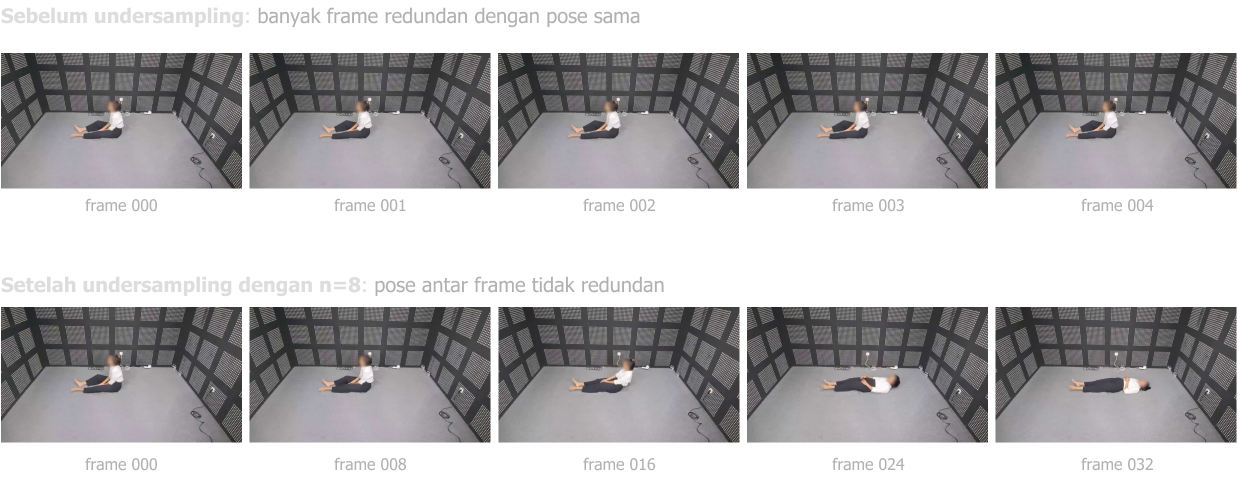

### 3.3.2. Undersampling Mechanism Detail

Selanjutnya akan dibahas bagaimana data akan di-sampling secara detail. Sampling akan dilakukan berdasarkan tujuan yang akan dicapai:

* (1) Permasalahan utama adalah prediksi *fall* dan *non-fall*, yakni sebuah *binary* prediction. Oleh karena itu, akan dilakukan sampling sehingga data akan memiliki proporsi *fall* vs *non-fall* mendekati 50:50
* (2) Telah diketahui pada bagian 2.2.3. bahwa kedua belas tipe *fall* dan *non-fall* memiliki proporsi yang berbeda-beda, dengan tipe seperti picking, strecthing, dan walking memiliki proporsi paling tinggi. Oleh karena itu, akan dilakukan sampling dengan sebaik mungkin mempertahankan proporsi antar kelas ini.

Berdasarkan kedua tujuan tersebut, didapatkan `n` (input rumus undersampling pada bagian 3.3.1.) untuk setiap kelas tipe *fall* dan *non-fall* seperti berikut:



```
# fall
'backward': 4,
'forward': 4,
'left': 4,
'right': 4,
'sitting': 7,
'standing': 4,

# non-fall
'jumping': 6,
'laying': 9,
'picking': 11,
'squat': 6,
'stretching': 8,
'walking': 7
```

a) proporsi *fall* vs *non-fall* sebelum sampling

In [ ]:
count = labels_df['label'].value_counts().get(1, 0)
proportion = labels_df['label'].value_counts(normalize=True).get(1, 0)

label_dist = pd.DataFrame({'label': [0, 1], "count": [labels_df['label'].value_counts().get(0, 0), count], 'proportion': [labels_df['label'].value_counts(normalize=True).get(0, 0), proportion]})
label_dist

label  count  proportion
0      0   2748    0.639963
1      1   1546    0.360037

b) proporsi tipe kedua belas *fall* dan *non-fall* sebelum sampling

In [ ]:
def subject_type_counts_proportion(labels_df):
    # Extract subject ID from the 'id' column
    labels_df['subject'] = labels_df['id'].str.split('_').str[0]

    # Group by subject and type, then count occurrences
    subject_type_counts = labels_df.groupby(['subject', 'type'])['id'].count().reset_index(name='count')

    # Calculate proportions within each subject
    subject_totals = subject_type_counts.groupby('subject')['count'].transform('sum')
    subject_type_counts['proportion'] = (subject_type_counts['count'] / subject_totals).round(2)

    # Pivot the table to have subjects as rows and types as columns
    subject_type_df = subject_type_counts.pivot(index='subject', columns='type', values='proportion')

    # Fill NaN values with 0 (if any)
    subject_type_df = subject_type_df.fillna(0)

    return subject_type_df

subject_type_df = subject_type_counts_proportion(labels_df)
display(subject_type_df)

type     backward  forward  jumping  laying  left  picking  right  sitting  \
subject                                                                      
1            0.05     0.06      0.1    0.10  0.05     0.11   0.05     0.07   
2            0.06     0.05      0.1    0.09  0.05     0.12   0.05     0.08   
3            0.06     0.06      0.1    0.09  0.05     0.14   0.07     0.06   
4            0.05     0.05      0.1    0.10  0.05     0.13   0.06     0.08   

type     squat  standing  stretching  walking  
subject                                        
1         0.10      0.08        0.13     0.10  
2         0.10      0.07        0.12     0.11  
3         0.09      0.07        0.10     0.10  
4         0.10      0.05        0.12     0.11

c) proporsi *fall* vs *non-fall* setelah sampling

In [ ]:
def sample_frames_by_type(labels_df):
    """
    Samples frames from the DataFrame based on the specified intervals for each type.

    Args:
        labels_df: DataFrame containing image labels and types.

    Returns:
        DataFrame: Sampled DataFrame with frames selected based on type intervals.
    """

    # Define sampling intervals for each type
    type_intervals = {
        'backward': 4,
        'forward': 4,
        'left': 4,
        'right': 4,
        'sitting': 7,
        'standing': 4,

        'jumping': 6,
        'laying': 9,
        'picking': 11,
        'squat': 6,
        'stretching': 8,
        'walking': 7
    }

    # Extract person ID and frame number from the id column
    labels_df['person_id'] = labels_df['id'].apply(lambda x: int(x.split('_')[0]))
    labels_df['frame_num'] = labels_df['id'].apply(lambda x: int(x.split('frame')[1].split('.')[0]))

    # Create an empty list to store sampled rows
    sampled_rows = []

    # Iterate through each row of the DataFrame
    for index, row in labels_df.iterrows():
        # Get the type and frame number for the current row
        current_type = row['type']
        current_frame_num = row['frame_num']

        # Check if the current frame number is a multiple of the interval for the current type
        if current_frame_num % type_intervals[current_type] == 0:
            # If it is, add the row to the sampled rows list
            sampled_rows.append(row)

    # Create a new DataFrame from the sampled rows
    sampled_df = pd.DataFrame(sampled_rows)

    return sampled_df[['id', 'label', 'type']]

sampled_labels_df = sample_frames_by_type(labels_df)
count = sampled_labels_df['label'].value_counts().get(1, 0)
proportion = sampled_labels_df['label'].value_counts(normalize=True).get(1, 0)

label_dist = pd.DataFrame({'label': [0, 1], "count": [sampled_labels_df['label'].value_counts().get(0, 0), count], 'proportion': [sampled_labels_df['label'].value_counts(normalize=True).get(0, 0), proportion]})
label_dist

label  count  proportion
0      0    373    0.521678
1      1    342    0.478322

d) proporsi tipe kedua belas *fall* dan *non-fall* setelah sampling

In [ ]:
subject_type_df = subject_type_counts_proportion(sampled_labels_df)
display(subject_type_df)

type     backward  forward  jumping  laying  left  picking  right  sitting  \
subject                                                                      
1            0.07     0.08     0.10    0.07  0.08     0.06   0.07     0.06   
2            0.08     0.07     0.10    0.07  0.08     0.07   0.07     0.07   
3            0.09     0.09     0.10    0.07  0.08     0.08   0.10     0.05   
4            0.07     0.07     0.11    0.07  0.07     0.08   0.08     0.07   

type     squat  standing  stretching  walking  
subject                                        
1         0.10      0.12        0.10     0.09  
2         0.10      0.10        0.09     0.10  
3         0.09      0.10        0.08     0.09  
4         0.10      0.08        0.09     0.10

### 3.3.3. Removing Outliers

Kami mengamati bahwa subjek 2 dengan tipe walking memiliki pose frame ke frame yang berbeda dibandingkan dengan subjek lain. Subjek 2 melakukan walking secara diagonal dari sisi ruang pojok kiri atas ke pojok kanan bawah. Arah walking ini berbeda dengan arah yang dilakukan oleh Subjek training lain bahkan subjek pada test set yang berjalan secara horizontal lurus dari kiri ke kanan. Oleh karena itu, kita menghapus gambar-gambar subjek 2 dengan tipe walking

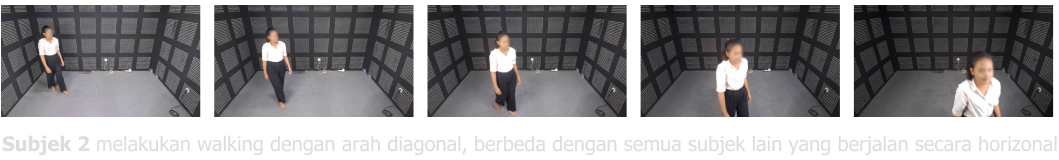

In [ ]:
# remove 2nd person walking as it is walking diagonally
sampled_labels_df = sampled_labels_df[~((sampled_labels_df['id'].str.startswith('2')) & (sampled_labels_df['type'] == 'walking'))]

## 3.4. Training and Validation Splitting

Telah diketahui bahwa test set terdiri dari 2 subjek yang tidak ada di train set. Maka dari itu, perlu melakukan splitting untuk mendapatkan validation set yang menyerupai test set, yaitu memilih salah satu subjek yang tidak di-*feed* ke model saat training. Sehingga, dipilih subjek 1 sebagai validation set.

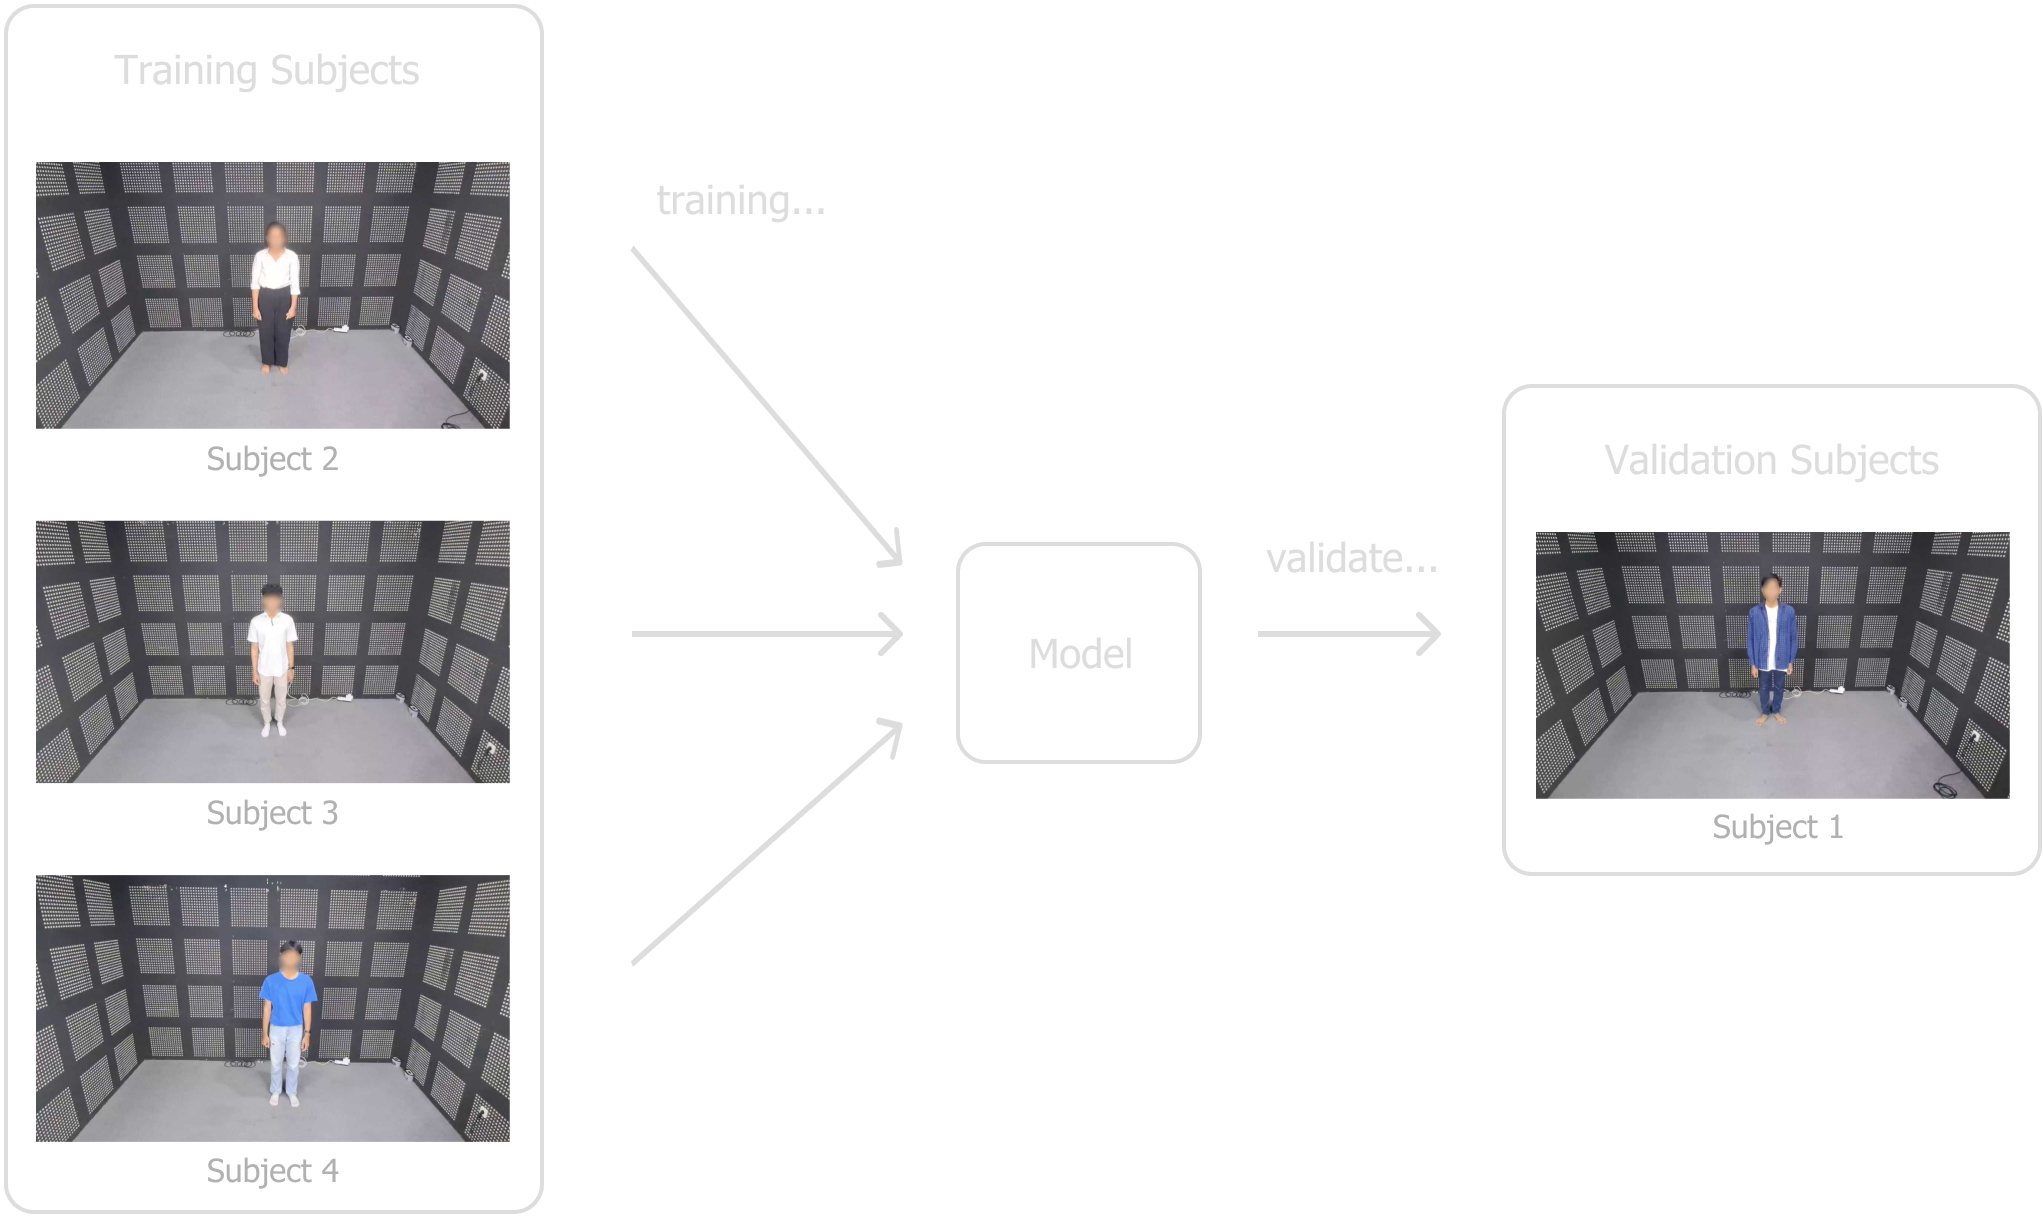

Kami membagi `sampled_labels_df` menjadi 3 set:

* `train_df`: subjek 2, 3, 4 dari `sampled_labels_df`
* `val_df`: subjek 1 dengan sampling n=4
* `heldout_val_df`: subjek 1 yang tidak berada di `val_df`

### 3.4.1. Creating train_df



In [ ]:
train_df = sampled_labels_df[~sampled_labels_df['id'].str.startswith('1')]
train_df = train_df[['id', 'label', 'type']]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 553 entries, 2 to 4276
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      553 non-null    object
 1   label   553 non-null    int64 
 2   type    553 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


### 3.4.2. Creating val_df

In [ ]:
def sample_frames_by_person(labels_df, n=0):
    # Extract person ID and frame number from the id column
    labels_df['person_id'] = labels_df['id'].apply(lambda x: int(x.split('_')[0]))
    labels_df['frame_num'] = labels_df['id'].apply(lambda x: int(x.split('frame')[1].split('.')[0]))

    # Filter frames that are multiples of 6 (000, 006, 012, etc.)
    sampled_df = labels_df[labels_df['frame_num'] % n == 0].copy()

    return sampled_df[['id', 'label', 'type']]

for_val_df = labels_df[labels_df['id'].str.startswith('1')]
val_df = sample_frames_by_person(for_val_df, n=4)
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221 entries, 91 to 4290
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      221 non-null    object
 1   label   221 non-null    int64 
 2   type    221 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.9+ KB


<ipython-input-19-60e8de5f0233>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_df['person_id'] = labels_df['id'].apply(lambda x: int(x.split('_')[0]))
<ipython-input-19-60e8de5f0233>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_df['frame_num'] = labels_df['id'].apply(lambda x: int(x.split('frame')[1].split('.')[0]))


### 3.4.3 Creating heldout_val_df

In [ ]:
heldout_val_df = for_val_df[~for_val_df.index.isin(val_df.index)]
heldout_val_df = heldout_val_df[['id', 'label', 'type']]
heldout_val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 664 entries, 1 to 4291
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      664 non-null    object
 1   label   664 non-null    int64 
 2   type    664 non-null    object
dtypes: int64(1), object(2)
memory usage: 20.8+ KB


## 3.5. Data Preprocessing and Augmentation

Pada pemodelan kali ini, kami melakukan dua metode preprocessing yaitu resizing image dan grayscaling image. Proses resized dilakukan untuk menekan kebutuhan resource yang digunakan untuk melatih model dan grayscaling image dilakukan karena informasi warna tidak dibutuhkan dalam kasus ini. Grayscale mendorong model model untuk fokus pada fitur-fitur yang lebih relevan (seperti bentuk dan pose).

Selain itu, untuk menambah jumlah data, kami melakukan augmentasi sederhana dengan cara melakukan rotasi image dengan sudut rotasi yang sangat kecil.

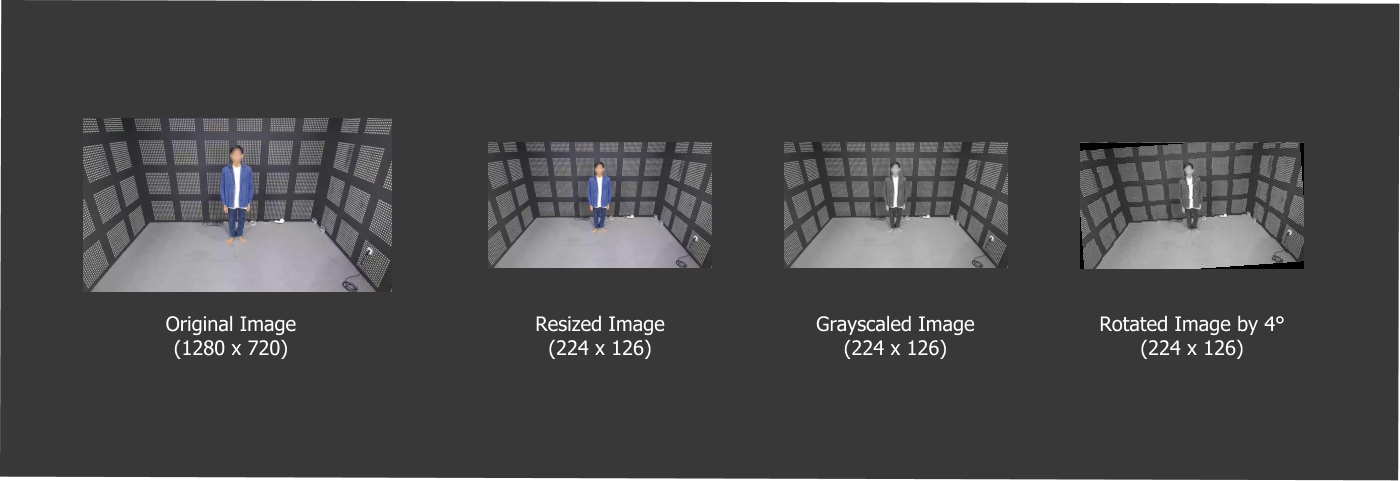

In [ ]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(degrees=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Selain augmentasi sederhana berupa rotasi, kami juga menerapkan sebuah teknik augmentasi bernama Mixup [1]. Teknik augmentasi ini menyatukan dua gambar beserta probabilitasnya seperti yang digambarkan pada visualisasi dibawah

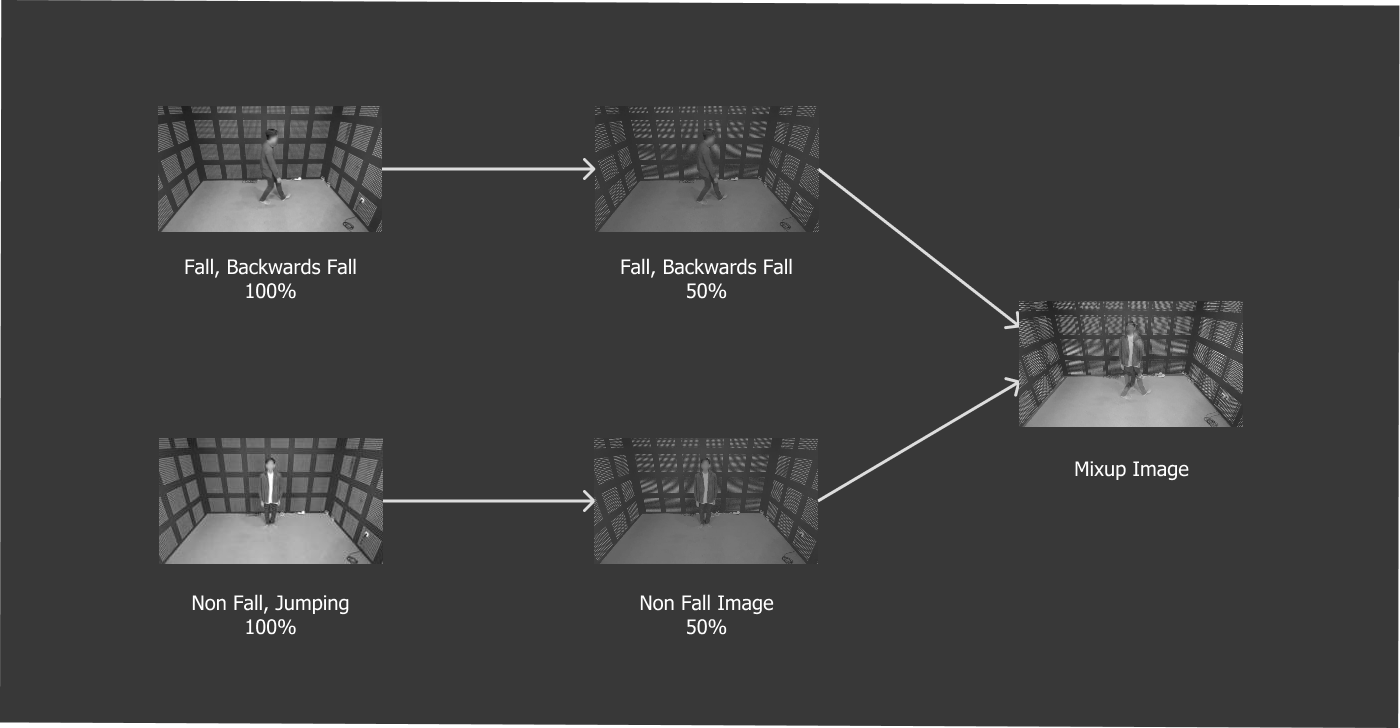

Pemilihan alpha yang kecil (yakni 0.4) dalam distribusi Beta(α, α) menghasilkan distribusi yang cenderung memberikan bobot yang lebih besar ke nilai-nilai di dekat 0 dan 1. Ini berarti bahwa λ akan lebih sering bernilai dekat 0 atau 1 daripada di tengah-tengah (0.5). Implikasinya adalah:

1.  **Menjaga Karakteristik Sampel Asli:** Dengan λ yang cenderung dekat 0 atau 1, sampel yang dihasilkan oleh Mixup akan lebih mirip dengan salah satu dari dua sampel asli. Ini penting karena kita ingin model tetap belajar karakteristik dari data yang sebenarnya. Jika λ sering berada di sekitar 0.5, sampel yang dihasilkan akan menjadi campuran yang "terlalu jauh" dari sampel aslinya, yang bisa mengganggu pembelajaran.

2.  **Regularisasi yang Lebih Efektif:** Mixup berfungsi sebagai bentuk regularisasi, mencegah model untuk terlalu percaya pada satu sampel data tertentu. Dengan alpha kecil, Mixup mendorong model untuk belajar representasi linear antara sampel-sampel, tetapi tetap mempertahankan identitas sampel asli dalam proporsi yang lebih besar. Ini membantu model untuk melakukan generalisasi yang lebih baik ke data yang belum pernah dilihat sebelumnya.

3.  **Distribusi Beta dan Ekor Probabilitas Tinggi:** Distribusi Beta dengan alpha < 1 (termasuk 0.4) memiliki karakteristik unik, yaitu probabilitas yang lebih tinggi di dekat 0 dan 1 (disebut "ekor" distribusi). Secara visual, grafiknya berbentuk U terbalik. Ini persis seperti yang kita inginkan dalam Mixup: lebih sering menggunakan nilai λ yang mendekati 0 atau 1.


In [ ]:
def mixup_data(images, labels, type_labels, alpha=0.4):
    """Apply mixup augmentation to data and labels.

    Args:
        images: Input images tensor
        labels: Binary fall labels tensor
        type_labels: Type classification labels tensor
        alpha: Mixup interpolation strength parameter

    Returns:
        Tuple of mixed images and labels
    """
     # Generate mixup weight from beta distribution
    lam = np.random.beta(alpha, alpha)

    # Create shuffled indices
    batch_size = images.size()[0]
    rand_idx = torch.randperm(batch_size).to(device)

     # Mix the images
    mixed_images = lam * images + (1 - lam) * images[rand_idx]

    # Mix the labels
    mixed_labels = lam * labels + (1 - lam) * labels[rand_idx]
    mixed_type_labels = lam * type_labels + (1 - lam) * type_labels[rand_idx]

    return mixed_images, mixed_labels, mixed_type_labels

# 4. Modelling

## 4.1. Define The Model

**KENAPA EFFICIENTNET??**

Arsitektur EffiecientNetB7 ini dirancang untuk multitask, yaitu fall detection (binary) dan fall type classification (multi-class classification). Hal ini dapat dilakukan dengan mengganti head classifier yang menjadi dari 2 output fall head dan type head. Model didorong untuk dapat memiliki akurasi yang tinggi dalam memprediksi label *fall* dengan cara juga dilatih untuk memprediksi tipe dari *fall* (forward, backward, left, right, standing, sitting) dan *non_fall* (laying, squat, jumping, picking, stretching, walking) [2].

Berikut merupakan arsitektur yang kami gunakan untuk pemodelan.


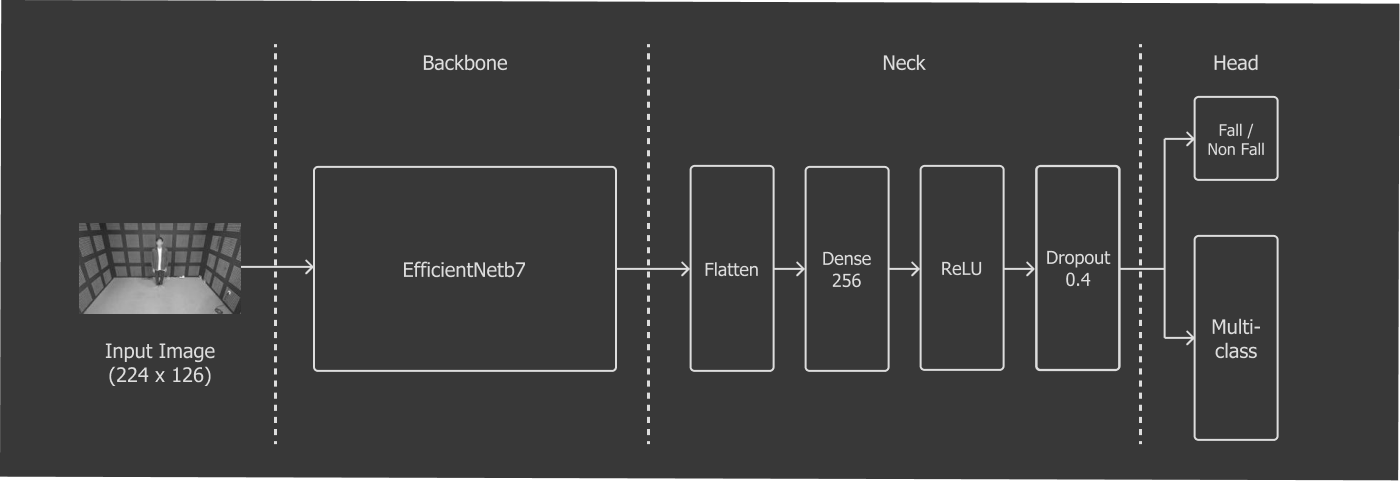

Arsitektur ini menggunakan EfficientNetb7 tanpa pretrained weight sebagai Backbone, satu *dense layer* dengan *ReLU activation function* dan satu *dropout layer* untuk Neck, serta membuat dua Head. Head pertama merupakan *binary classification* antara *fall* dan *non fall* sedangkan Head kedua merupakan *multiclass classification* antar *sub-label*.

Fine-tuning dilakukan secara menyeluruh (semua parameter backbone di-*unfroze*) yang biasanya menghasilkan akurasi yang lebih baik daripada hanya melatih lapisan linear terakhir [3,4,5,6].

Arsitektur tersebut diimplementasikan dalam bentuk Torch function sebagai berikut

In [ ]:
class EfficientNetB7(nn.Module):
    def __init__(self, num_type_classes):
        super(EfficientNetB7, self).__init__()
        self.backbone = models.efficientnet_b7(weights=models.EfficientNet_B7_Weights.DEFAULT)

        # Unfroze backbone
        for param in self.backbone.parameters():
            param.requires_grad = True

        num_ftrs = self.backbone.classifier[-1].in_features

        self.backbone.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_ftrs, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4)
        )

        # Separate heads for fall detection and type classification
        self.fall_head = nn.Linear(256, 1)
        self.type_head = nn.Linear(256, num_type_classes)

    def forward(self, x):
        features = self.backbone(x)

        fall_pred = self.fall_head(features)
        type_pred = self.type_head(features)

        return torch.cat([fall_pred, type_pred], dim=1)

## 4.2. Load Data into Custom Dataset

Kode berikut men-*load* dataset menggunakan kode yang telah di-*define* sebelumnya.

In [ ]:
path_to_fall = '/content/data/train/fall/'
path_to_non_fall = '/content/data/train/non_fall/'
img_dirs = [path_to_fall, path_to_non_fall]

label_encoder = LabelEncoder()

# datasets
train_dataset = FallDataset(
    train_df,
    img_dirs=img_dirs,
    transform=train_transform,
    label_encoder=label_encoder
)

val_dataset = FallDataset(
    val_df,
    img_dirs=img_dirs,
    transform=val_transform,
    label_encoder=label_encoder
)

heldout_val_dataset = FallDataset(
    heldout_val_df,
    img_dirs=img_dirs,
    transform=val_transform,
    label_encoder=label_encoder
)

# dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=12,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=12,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

heldout_val_loader = DataLoader(
    heldout_val_dataset,
    batch_size=12,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

## 4.3. Model Training

### 4.3.1. Instantiate model

Kode ini menginisialisasi model EfficientNetB7 dengan jumlah kelas label *type* berjumlah 12, memindahkannya ke perangkat komputasi (CPU atau GPU), dan menyiapkan optimizer Adam untuk melatih parameter model dengan learning rate awal 5e-5. Selain itu, kode juga menerapkan learning rate scheduler ReduceLROnPlateau yang akan secara dinamis menyesuaikan learning rate selama pelatihan jika *validation loss* tidak mengalami penurunan.

In [ ]:
# Instantiate model for this fold
model = EfficientNetB7(num_type_classes=train_dataset.num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 161MB/s]


### 4.3.2. Loss Function and Evaluation Metrics

Pada task ini, kami menggunakan *Binary Cross Entropy* sebagai *loss function* untuk *binary classification task* dan *Cross Entropy* sebagai *loss function* untuk *multiclass classification*. Persamaan kedua *loss function* tersebut berturut turut adalah sebagai berikut.

$$ \mathcal{L}_{BCE} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(\sigma(x_i)) + (1 - y_i) \cdot \log(1 - \sigma(x_i)) \right]$$

$$\
\mathcal{L}_{\text{CE}} = -\frac{1}{N} \sum_{n=1}^N \sum_{c=1}^C y_{n,c} \log \left( \frac{\exp(x_{n,c})}{\sum_{i=1}^C \exp(x_{n,i})} \right)
\
$$

Adapun untuk menguji performa model yang telah dibuat, kami meninjau dari dua metrik evaluasi yaitu Accuracy dan F1-Score. Kedua metrik tersebut didefinisikan oleh persamaan berikut.

$$
\text{Accuracy} =  \frac{\sum_{i=1}^N \mathbb{1}(\hat{y}_i = y_i)}{N}
$$

$$
\text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

### 4.3.3. Define The Function for Training

In [ ]:
def calculate_metrics(loader, model, mode):
    """Calculate metrics for both fall/non-fall and type classification."""
    model.eval()
    fall_total_loss = 0.0
    type_total_loss = 0.0
    all_fall_preds = []
    all_fall_labels = []
    all_type_preds = []
    all_type_labels = []

    with torch.no_grad():
        for images, labels, type_labels in tqdm(loader, desc=f"Calculating {mode} Metrics"):
            images, labels, type_labels = images.to(device), labels.to(device).float(), type_labels.to(device)
            outputs = model(images)

            fall_loss = F.binary_cross_entropy_with_logits(outputs[:, 0].unsqueeze(1), labels)
            type_loss = F.cross_entropy(outputs[:, 1:], torch.argmax(type_labels, dim=1))

            fall_total_loss += fall_loss.item()
            type_total_loss += type_loss.item()

            fall_preds = (torch.sigmoid(outputs[:, 0].unsqueeze(1)) > 0.5).float()
            all_fall_preds.extend(fall_preds.cpu().numpy())
            all_fall_labels.extend(labels.cpu().numpy())

            type_preds = torch.argmax(torch.sigmoid(outputs[:, 1:]), dim=1)
            type_labels_argmax = torch.argmax(type_labels, dim=1)

            all_type_preds.extend(type_preds.cpu().numpy())
            all_type_labels.extend(type_labels_argmax.cpu().numpy())


    fall_metrics = {
        'loss': fall_total_loss / len(loader),
        'accuracy': accuracy_score(all_fall_labels, all_fall_preds),
        'f1_score': f1_score(all_fall_labels, all_fall_preds)
    }
    type_metrics = {
        'loss': type_total_loss / len(loader),
        'accuracy': accuracy_score(all_type_labels, all_type_preds),
        'f1_score': f1_score(all_type_labels, all_type_preds, average='weighted')
    }

    return fall_metrics, type_metrics


class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


def train(model, train_loader, val_loader, num_epochs=15, patience=4, mixup_alpha=0.4):

    train_fall_losses, val_fall_losses = [], []
    train_type_losses, val_type_losses = [], []

    best_val_loss = np.inf
    best_val_accuracy = 0.0

    best_model_state = None

    early_stopping = EarlyStopping(patience=patience)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_fall_loss = 0.0
        train_type_loss = 0.0

        print(f"=============== EPOCH {epoch + 1} ===============\n")

        current_lr = optimizer.param_groups[0]['lr']
        print(f'Current Learning Rate: {current_lr}')
        for images, labels, type_labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            type_labels = type_labels.to(device)

            optimizer.zero_grad()

            mixed_images, mixed_labels, mixed_type_labels = mixup_data(
                images, labels, type_labels, alpha=mixup_alpha
            )

            # Use mixed data
            outputs = model(mixed_images)
            fall_loss = F.binary_cross_entropy_with_logits(
                outputs[:, 0].unsqueeze(1),
                mixed_labels
            )
            type_loss = F.cross_entropy(
                outputs[:, 1:],
                mixed_type_labels  # Keep the mixed soft labels
            )

            loss = fall_loss + 0.5 * type_loss
            loss.backward()
            optimizer.step()

            train_fall_loss += fall_loss.item()
            train_type_loss += type_loss.item()

        # Calculate metrics
        train_fall_metrics, train_type_metrics = calculate_metrics(train_loader, model, "Train")
        val_fall_metrics, val_type_metrics = calculate_metrics(val_loader, model, "Val")

        # Store losses
        train_fall_losses.append(train_fall_loss / len(train_loader))
        val_fall_losses.append(val_fall_metrics['loss'])
        train_type_losses.append(train_type_loss / len(train_loader))
        val_type_losses.append(val_type_metrics['loss'])

        print(
        f"Train Fall Loss:\t {train_fall_metrics['loss']:.4f}, \n"
        f"Val Fall Loss:\t\t {val_fall_metrics['loss']:.4f}, \n\n"

        f"Train Fall Accuracy:\t {train_fall_metrics['accuracy']:.4f}, \n"
        f"Val Fall Accuracy:\t {val_fall_metrics['accuracy']:.4f}, \n"
        f"Val Fall F1:\t\t {val_fall_metrics['f1_score']:.4f}, \n\n"

        f"Train Type Accuracy:\t {train_type_metrics['accuracy']:.4f}, \n"
        f"Val Type Accuracy:\t {val_type_metrics['accuracy']:.4f}, \n"
        f"Val Type F1:\t\t {val_type_metrics['f1_score']:.4f} \n\n"
        )

        # Update best model state
        if val_fall_metrics['loss'] < best_val_loss:
            best_val_loss = val_fall_metrics['loss']
            best_val_accuracy = val_fall_metrics['accuracy']
            best_type_accuracy = val_type_metrics['accuracy']
            best_model_state = model.state_dict().copy()

        # Learning rate scheduling and early stopping
        scheduler.step(val_fall_metrics['loss'])
        early_stopping(val_fall_metrics['loss'])

        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    plt.figure(figsize=(10, 5))
    plt.plot(train_fall_losses, label="Train Fall Loss")
    plt.plot(val_fall_losses, label="Validation Fall Loss")
    plt.plot(train_type_losses, label="Train Type Loss")
    plt.plot(val_type_losses, label="Validation Type Loss")
    plt.title(f"Fall Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    result = {
        'best_val_loss': best_val_loss,
        'best_val_accuracy': best_val_accuracy,
        'best_type_accuracy': best_type_accuracy,
        'best_model_state': best_model_state
    }

    return result

### 4.3.4. Train The Model

Kode berikut merupakan kode yang digunakan untuk melatih model. Karena melatih model membutuhkan sumber daya yang besar, kami men-*comment* kode tersebut dan menunjukkan contoh print per epoch dan kurva penurunan loss tiap epochnya. Kami juga sudah menyediakan model yang telah dilatih sebelumnya!. Namun apabila anda tertarik untuk melatih model dan menunggu, silahkan un-*comment* dan jalankan kode kode berikut!

In [ ]:
# result = train(model, train_loader, val_loader, num_epochs=30, patience=6)



```
# Contoh Epoch
=============== EPOCH 21 ===============

Current Learning Rate: 5.000000000000001e-07
100%
 47/47 [00:36<00:00,  1.68it/s]
Calculating Train Metrics: 100%
 47/47 [00:11<00:00,  4.81it/s]
Calculating Val Metrics: 100%
 7/7 [00:04<00:00,  1.63it/s]
Train Fall Loss:	 0.0284,
Val Fall Loss:		 0.1633,

Train Fall Accuracy:	 1.0000,
Val Fall Accuracy:	 0.9683,
Val Fall F1:		 0.9548,

Train Type Accuracy:	 0.9982,
Val Type Accuracy:	 0.6154,
Val Type F1:		 0.5304
```



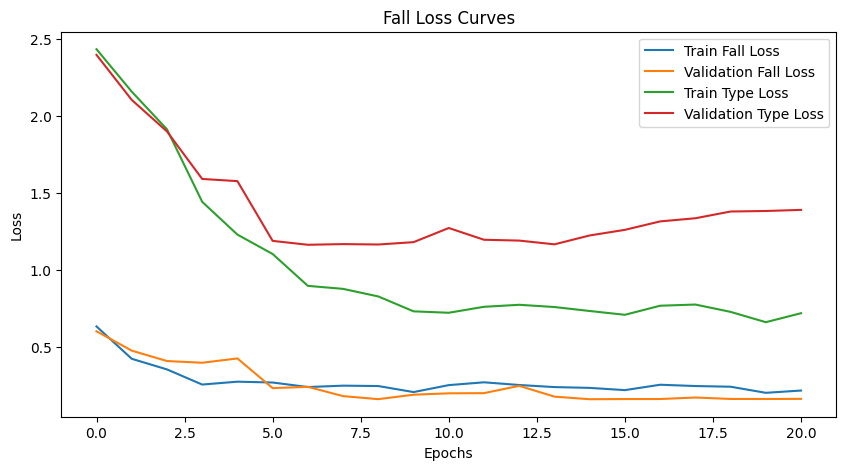

# 5. Result Analysis and Evaluation

## 5.1. Best Validation Score

In [ ]:
# === UNCOMMENT JIKA ANDA MEN-TRAIN ULANG MODEL! ===
#print(f"Best val loss: {result['best_val_loss']}")
#print(f"Best val acc: {result['best_val_accuracy']}")
#print(f"Best type acc: {result['best_type_accuracy']}")


Apabila anda men-train ulang model, maka kode diatas akan menampilkan skor terbaik seperti yang ada dibawah ini.
```
Best val loss: 0.16088079341820308
Best val acc: 0.9864253393665159
Best type acc: 0.6470588235294118
```



Kode dibawah merupakan kode untuk menyimpan model dalam bentuk .pth . Silahkan *uncomment* bagian atas apabila anda tidak men-*train* dari awal dan *un-comment* bagian bawah apabila anda men-*train* model dari awal.

In [ ]:
''' UNCOMMENT THIS TO SAVE MODEL '''
# torch.save(model.state_dict(), '/content/model_raw_mixup_v4.pth')


''' UNCOMMENT THIS TO LOAD THE TRAINED MODEL '''
!wget https://dataslayer-bucket.s3.us-east-1.amazonaws.com/model_raw_mixup_v4.pth
model = EfficientNetB7(num_type_classes=12).to(device)
model.load_state_dict(torch.load('/content/model_raw_mixup_v4.pth' ))

--2024-12-25 15:47:01--  https://dataslayer-bucket.s3.us-east-1.amazonaws.com/model_raw_mixup_v4.pth
Resolving dataslayer-bucket.s3.us-east-1.amazonaws.com (dataslayer-bucket.s3.us-east-1.amazonaws.com)... 3.5.20.232, 52.217.204.186, 52.216.57.194, ...
Connecting to dataslayer-bucket.s3.us-east-1.amazonaws.com (dataslayer-bucket.s3.us-east-1.amazonaws.com)|3.5.20.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 259498110 (247M) [binary/octet-stream]
Saving to: ‘model_raw_mixup_v4.pth’

model_raw_mixup_v4. 100%[===================>] 247.48M  15.2MB/s    in 18s     

2024-12-25 15:47:20 (13.6 MB/s) - ‘model_raw_mixup_v4.pth’ saved [259498110/259498110]



<ipython-input-29-21efea4f3b7c>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/model_raw_mixup_v4.pth' ))


<All keys matched successfully>

## 5.2. Validation Data Misclassified Image Visualization

Kami mencoba menampilkan gambar mana saja di validation dataset yang gagal diprediksi oleh model.

Predicting:   0%|          | 0/56 [00:00<?, ?it/s]

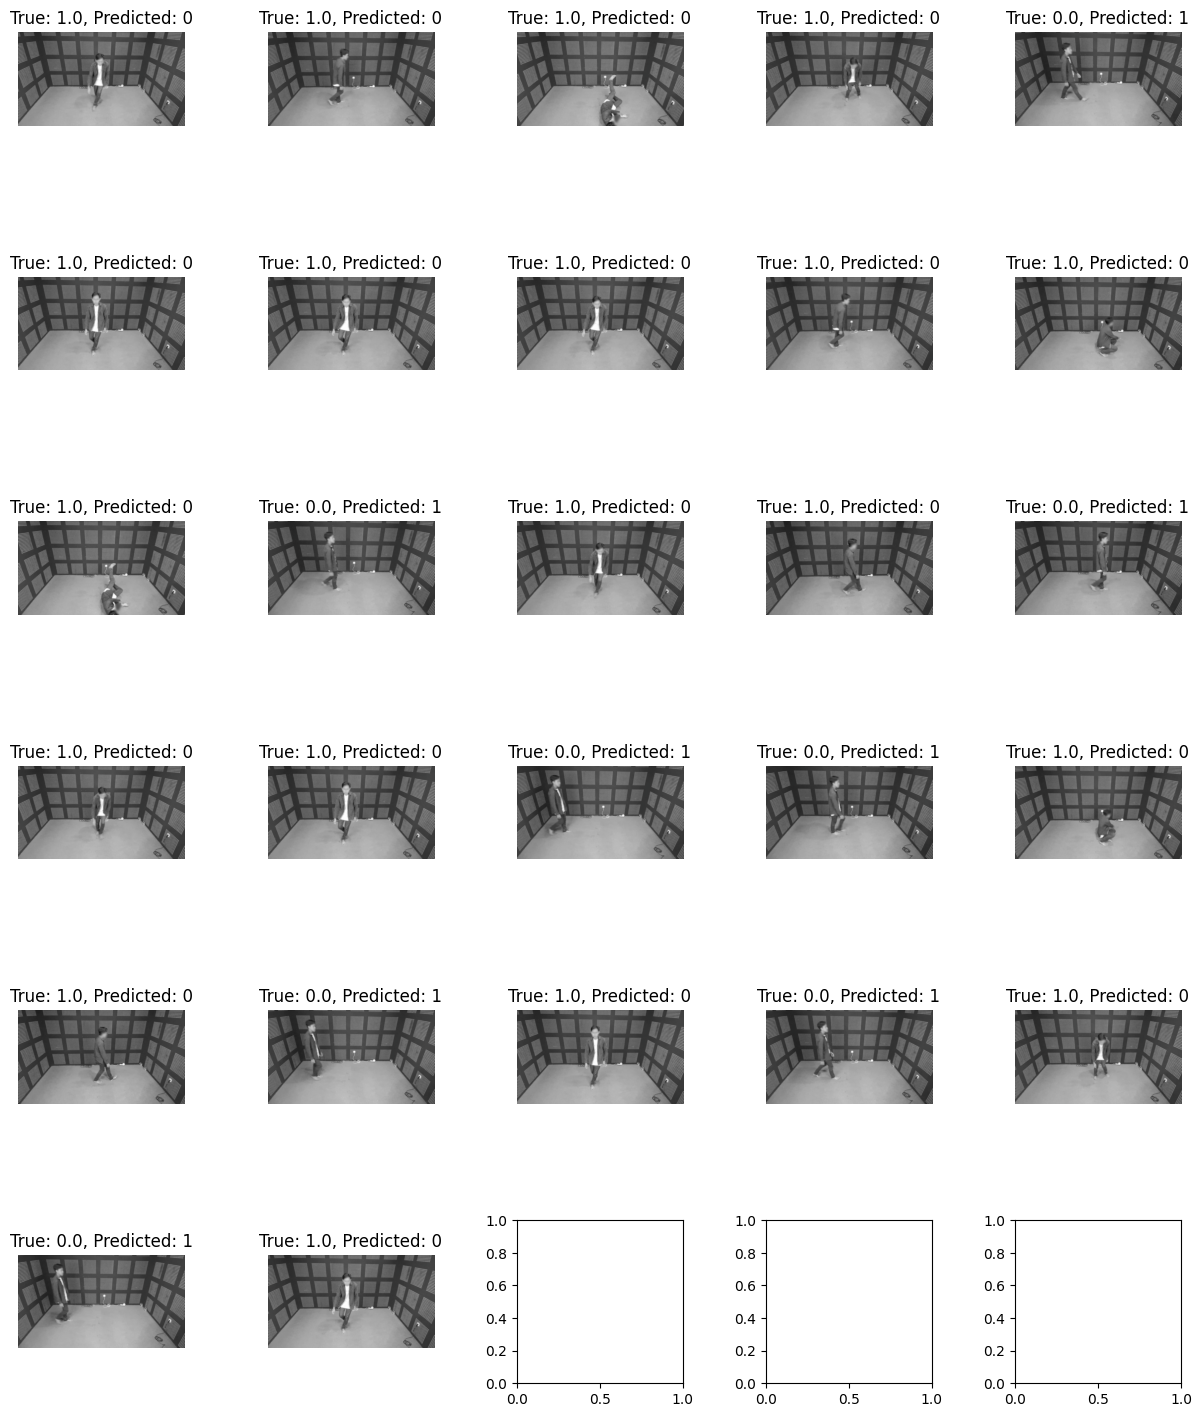

In [ ]:
def visualize_misclassified_images(model, val_loader, label_encoder=None, device="cuda"):
    model.eval()
    misclassified_images = []
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels, type_labels in tqdm(val_loader, desc="Predicting"):
            images, labels, type_labels = images.to(device), labels.to(device).float(), type_labels.to(device)

            # Get model predictions
            outputs = model(images)
            fall_preds = (torch.sigmoid(outputs[:, 0]) > 0.5).int().cpu().numpy()
            type_preds = torch.argmax(torch.sigmoid(outputs[:, 1:]), dim=1).cpu().numpy()

            # Compare predictions to true labels and store misclassified images
            for i in range(len(labels)):
                if fall_preds[i] != labels[i].item():  # If fall prediction is incorrect
                    misclassified_images.append(images[i].cpu().numpy())
                    true_labels.append(labels[i].item())
                    predicted_labels.append(fall_preds[i])  # Store predicted fall label

    # Display the misclassified images
    num_rows = (len(misclassified_images) + 4) // 5  # Calculate rows dynamically, 5 cols
    num_cols = min(len(misclassified_images), 5)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))  # Adjust height

    for i, image in enumerate(misclassified_images):
        # Undo normalization and convert to RGB
        image = image.transpose(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)

        row = i // 5
        col = i % 5

        if num_rows == 1:  # Handle single row
            if num_cols ==1:
                ax = axes
            else:
                ax = axes[col]
        elif num_cols == 1:
            ax = axes[row]
        else:
            ax = axes[row, col]

        ax.imshow(image)
        ax.set_title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
        ax.axis("off")

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()


visualize_misclassified_images(model, heldout_val_loader, label_encoder=label_encoder)

## 5.3. Multiclass Confusion Matrix

Evaluating:   0%|          | 0/56 [00:00<?, ?it/s]

Fall Accuracy: 0.9593
Type Accuracy: 0.6160



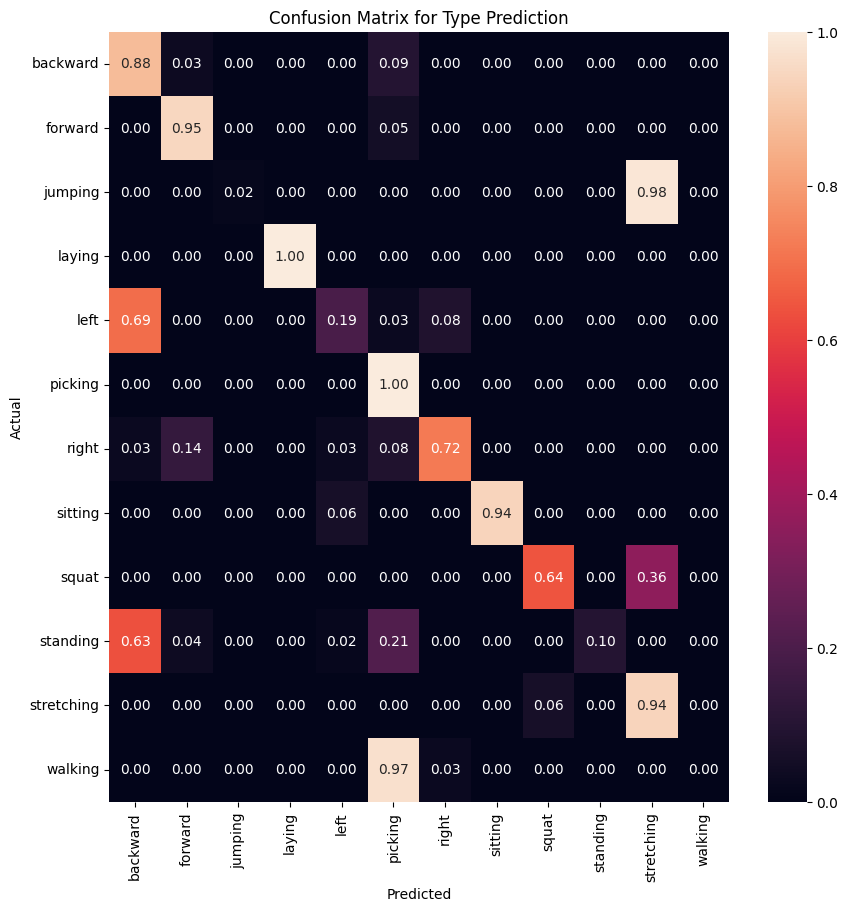

In [ ]:
def evaluate_heldout_set(model, loader, label_encoder):
  model.eval()
  all_fall_preds = []
  all_fall_labels = []
  all_type_preds = []
  all_type_labels = []

  with torch.no_grad():
    for images, labels, type_labels in tqdm(loader, desc="Evaluating"):
      images, labels, type_labels = images.to(device), labels.to(device).float(), type_labels.to(device)
      outputs = model(images)

      # Fall predictions
      fall_preds = (torch.sigmoid(outputs[:, 0].unsqueeze(1)) > 0.5).float()
      all_fall_preds.extend(fall_preds.cpu().numpy())
      all_fall_labels.extend(labels.cpu().numpy())

      # Type predictions
      type_preds = torch.argmax(torch.sigmoid(outputs[:, 1:]), dim=1)
      all_type_preds.extend(type_preds.cpu().numpy())
      type_labels_argmax = torch.argmax(type_labels, dim=1)  # Get argmax for type labels
      all_type_labels.extend(type_labels_argmax.cpu().numpy())

  # Calculate fall accuracy
  fall_accuracy = accuracy_score(all_fall_labels, all_fall_preds)

  # Calculate type accuracy
  type_accuracy = accuracy_score(all_type_labels, all_type_preds)

  # Print accuracies
  print(f"Fall Accuracy: {fall_accuracy:.4f}")
  print(f"Type Accuracy: {type_accuracy:.4f}\n")

  # Create confusion matrix
  cm = confusion_matrix(all_type_labels, all_type_preds)

  # Get class names from LabelEncoder
  class_names = label_encoder.classes_

  # Normalize confusion matrix for better visualization
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  # Display confusion matrix using seaborn heatmap
  fig, ax = plt.subplots(figsize=(10, 10))
  sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, ax=ax)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title('Confusion Matrix for Type Prediction')
  plt.show(block=False)  # Prevent blocking execution in notebooks

evaluate_heldout_set(model, heldout_val_loader, label_encoder)

Dapat dilihat bahwa model mengalami kesulitan dalam membedakan beberapa aktivitas yang memiliki fitur visual serupa. Aktivitas seperti *left* dan *right*. Aktivitas *squat* juga memiliki akurasi rendah (0.64) dan sering diklasifikasikan sebagai *standing* (0.21) atau *stretching* (0.10), kemungkinan akibat postur tubuh yang mirip. Selain itu, aktivitas *standing* hanya memiliki akurasi 0.63, dengan banyak kesalahan prediksi sebagai *backward* (0.09), menunjukkan sensitivitas model yang kurang dalam membedakan postur berdiri dan mundur. Akan tetapi, mayoritas dari visual yang serupa akan tetap diklasifikasikan sebagai
fall dan non fall.


# 6. Test Set Prediction

In [ ]:
sample_submission = pd.read_csv('/content/data/sample_submission.csv')
test_ids = sample_submission['id'].values
test_df = pd.DataFrame({'id': test_ids})

# Set is_test=True to make the loader returning only images
test_dataset = FallDataset(df=test_df, img_dirs=['/content/data/test/'], transform=val_transform, is_test=True)
submission_loader = DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=2, pin_memory=True)

# Function to generate predictions
def generate_predictions(model, submission_loader):
    model.eval()
    fall_preds, type_preds = [], []

    with torch.no_grad():
        for images in tqdm(submission_loader, desc="Predicting", total=len(submission_loader)):
            images = images.to(device)
            outputs = model(images)

            # Extract separate predictions for fall/non-fall and type
            fall_preds_batch = (torch.sigmoid(outputs[:, 0]) > 0.5).int().cpu().numpy()
            type_preds_batch = torch.argmax(torch.sigmoid(outputs[:, 1:]), dim=1).cpu().numpy()

            fall_preds.extend(fall_preds_batch.squeeze().tolist())
            type_preds.extend(type_preds_batch.tolist())

    return fall_preds, type_preds

# Create submission Data Frame
fall_preds, type_preds = generate_predictions(model, submission_loader)
submission_df = pd.DataFrame({'id': test_ids, 'label': fall_preds })
submission_df.info()

Predicting:   0%|          | 0/180 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152 entries, 0 to 2151
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2152 non-null   object
 1   label   2152 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.8+ KB


In [ ]:
count = submission_df['label'].value_counts().get(1, 0)
proportion = submission_df['label'].value_counts(normalize=True).get(1, 0)

label_dist = pd.DataFrame({'label': [0, 1], "count": [submission_df['label'].value_counts().get(0, 0), count], 'proportion': [submission_df['label'].value_counts(normalize=True).get(0, 0), proportion]})
label_dist

label  count  proportion
0      0   1310    0.608736
1      1    842    0.391264

In [ ]:
submission_df.to_csv('submission.csv', index=False)

#References

[1] *Hongyi Zhang, Moustapha Cisse, Yann N Dauphin, and David Lopez-Paz. mixup: Beyond empirical risk minimization. 2017.https://arxiv.org/abs/1710.09412.*

[2] *Ruder, S. (2017). An overview of multi-task learning in deep neural networks. arXiv preprint arXiv:1706.05098.*

[3] *Simon Kornblith, Jonathon Shlens, and Quoc V Le. Do better imagenet models transfer better? In Conference on Computer Vision and Pattern Recognition (CVPR), 2019. https://arxiv.org/abs/1805.08974.*

[4] *Pulkit Agrawal, Ross Girshick, and Jitendra Malik. Analyzing the performance of multilayer neural networks for object recognition. In European conference on computer vision, pages 329–344. Springer, 2014.*

[5] *Ken Chatfield, Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. Return of the devil in the details: Delving deep into convolutional nets. In British Machine Vision Conference, 2014.*

[6] *Hossein Azizpour, Ali Sharif Razavian, Josephine Sullivan, Atsuto Maki, and Stefan Carlsson. From generic to specific deep representations for visual recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition workshops, pages 36–45, 2015.*

